In [1]:
import numpy as np
import matplotlib.pyplot as plt

Define some hyperparameters of the genetic algortihm

In [2]:
pop_size = 100
num_genes = 100
generations = 100

# percentage of winner's genotype that will be copied into the loser
cross_perc = 0.5 

prob_mut = 0.01
elitism = True

Define some basic functions

In [ ]:
def relation_matrix(pop_size, num_genes):
  matrix = np.random.choice([-1,1], size=(pop_size, num_genes))
  sym = (matrix * matrix.T)
  np.fill_diagonal(sym, 0)

  return sym

def mutate(s, p):
  return np.random.choice([1,-1], size=s, p=[1 - p, p])

def fitness_function(relations, genotype):
  return np.sum(relations * (genotype[np.newaxis].T @ genotype[np.newaxis]))

def crossover(winner, loser, p):
  indices = sorted(np.random.choice(list(range(0,len(winner))), size=round(len(winner)*p), replace=False))
  values = winner[np.ix_(indices)]
  np.put(loser, indices, values)

  return loser

In [ ]:
# init random relationship matrix
relations_random = np.random.choice([1,-1], size=(pop_size, num_genes))
np.fill_diagonal(relations_random, 0)

Roulette wheel selection 

In [3]:
def party_wheel(pop_size, num_genes, generations, prob_mut):

  # init population
  population = np.random.choice([-1,1], size=(pop_size, num_genes))

  # init individual fitness
  fitness = [fitness_function(relations, population[[x],:]) for x in range(pop_size)]

  elitism = True
  fitness_over_time = np.zeros(generations)

  for g in range(generations):
    new_pop = np.zeros((pop_size, num_genes))
    new_fitness = np.zeros(pop_size)

    # sort population by fitness (argsort returns the indices that would sort the fitness vector)
    ranked_fitness = np.argsort(fitness)

    # roulette wheel
    wheel = np.cumsum(range(pop_size))
    max_wheel = sum(range(pop_size))

    # elitism: add the individual with the highest fitness to the new population
    max_ind = ranked_fitness[-1]
    new_pop[0,:] = population[max_ind,:]
    new_fitness[0] = fitness[max_ind]

    # roulette wheel selection
    start_point = 1 if elitism else 0
    for i in range(start_point, pop_size):

      # pick individuals (looping twice to find wheel indice for each parent)
      wheel_inds = [np.argmax(wheel>np.random.randint(0,max_wheel)) for ind in range(2)]
      
      # get indices of the two selected parents
      ind1 = ranked_fitness[wheel_inds[0]]  
      ind2 = ranked_fitness[wheel_inds[1]]

      # get genotype of each parent
      parent1 = population[ind1,:]
      parent2 = population[ind2,:]

      # crossover to create children
      cross_over_point = np.random.choice(range(num_genes))
      parent1_genes = parent1[:cross_over_point]
      parent2_genes = parent2[cross_over_point:]
      child_genes = np.hstack([parent1_genes, parent2_genes])
      
      # mutate child
      child_genotype = np.multiply(child_genes, mutate(num_genes, prob_mut))
      new_pop[[i],:] = child_genotype
      new_fitness[i] = fitness_function(relations, new_pop[i])

    population = new_pop
    fitness = new_fitness

    fitness_over_time[g] = max(fitness)

  return fitness_over_time

Microbial genetic algorithm

In [4]:
def party_microbial(pop_size, num_genes, generations, prob_mut):
  # init population
  population = np.random.choice([-1,1], size=(pop_size, num_genes))

  # init random relationship matrix
  relations = relation_matrix(pop_size, num_genes)

  # init fitness
  fitness = [fitness_function(relations, population[x]) for x in range(pop_size)]
  
  fitness_over_time = np.zeros(generations)

  for g in range(generations):
    for i in range(pop_size):
      # 2 individuals that are going to compete
      ind1, ind2 = np.random.choice(list(range(pop_size)), size=2)

      # select the individual with highest fitness, then copy and mutate loser
      if fitness[ind1] < fitness[ind2]:
        population[ind1] = np.multiply(population[ind2], mutate(num_genes, prob_mut))
        fitness[ind1] = fitness_function(relations, population[ind1])

      else:
        population[ind2] = np.multiply(population[ind1], mutate(num_genes, prob_mut))
        fitness[ind2] = fitness_function(relations, population[ind2])

    fitness_over_time[g] = max(fitness)
  
  return fitness_over_time

Microbial genetic algorithm with crossover

In [5]:
def party_microbial_cross(pop_size, num_genes, generations, prob_mut, p):
  # init population
  population = np.random.choice([-1,1], size=(pop_size, num_genes))

  # random relationship matrix
  relations = relation_matrix(pop_size, num_genes)

  # init fitness
  fitness = [fitness_function(relations, population[x]) for x in range(pop_size)]

  fitness_over_time = np.zeros(generations)

  for g in range(generations):
    for i in range(pop_size):
      # 2 individuals that are going to compete
      ind1, ind2 = np.random.choice(list(range(pop_size)), size=2)

      # select the individual with highest fitness, then do crossover and mutate in loser
      if fitness[ind1] < fitness[ind2]:
        winner = population[ind2,:]
        population[ind1] = crossover(winner, population[ind1], p)
        population[ind1] = np.multiply(population[ind1], mutate(num_genes, prob_mut))
        fitness[ind1] = fitness_function(relations, population[ind1])

      else:
        winner = population[ind1,:]
        population[ind2] = crossover(winner, population[ind2], p)
        population[ind2] = np.multiply(population[ind2], mutate(num_genes, prob_mut))
        fitness[ind2] = fitness_function(relations, population[ind2])

    fitness_over_time[g] = max(fitness)
  
  return fitness_over_time

Execute each algorithm with different mutations rate

In [6]:
# init results
mean_micro = []
std_micro = []
mean_cross = []
std_cross = []

# mutation range
mutations = np.arange(0.01, 0.22, 0.05)

samples = 10
for m in mutations:
  fitness_micro_muts = []
  fitness_micro_cross_muts = []

  for s in range(samples):
    # fitness_wheel += party_wheel(pop_size, num_genes, generations, prob_mut)
    fitness_micro_muts.append(party_microbial(pop_size, num_genes, generations, m))
    fitness_micro_cross_muts.append(party_microbial_cross(pop_size, num_genes, generations, m, cross_perc))

  mean_micro.append(np.mean(fitness_micro_muts, axis=0))
  std_micro.append(np.std(fitness_micro_muts, axis = 0))
  mean_cross.append(np.mean(fitness_micro_cross_muts, axis = 0))
  std_cross.append(np.std(fitness_micro_cross_muts, axis = 0))

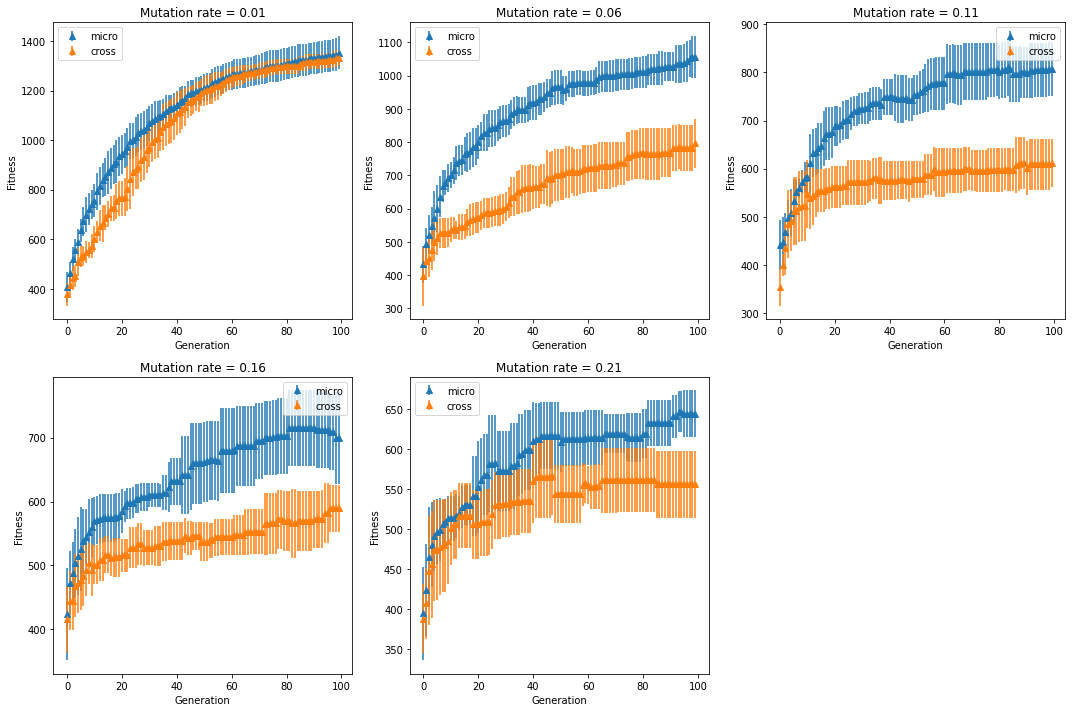

In [10]:
means = [[mean_micro[r], mean_cross[r]] for r in range(len(mutations))]
stds = [[std_micro[r], std_cross[r]] for r in range(len(mutations))]
xs = [list(range(generations)) for i in range(len(means[0]))]

labels = ['micro', 'cross']
titles = ['Mutation rate = ' + str(round(x, 2)) for x in mutations]
f, axs = plt.subplots(2,2,figsize=(15,10))

for p in range(len(mutations)):
  plt.subplot(2,3,p + 1)
  for i in range(len(xs)):
    plt.errorbar(xs[i], means[p][i], stds[p][i], label=labels[i], linestyle='None', marker='^')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
  plt.legend(loc='best')
  title = plt.title(titles[p])


plt.tight_layout()